In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/.julia/dev/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1342


In [2]:
dd = IMAS.json2imas(joinpath(dirname(abspath(@__FILE__)),"..","sample","CAT_eq_ods.json"));
IMAS.flux_surfaces(dd.equilibrium);
plot(dd.equilibrium.time_slice[1]);

In [3]:
ϵ = 0.32
κ = 1.7
δ = 0.3
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 3.0
x_point=true
symmetric=true

resolution = 129

dd = IMAS.dd()
resize!(dd.equilibrium.time_slice,1)
FUSE.init(dd.equilibrium.time_slice[1]; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=x_point)

eqactor = FUSE.SolovevEquilibriumActor(dd.equilibrium.time_slice[1], symmetric=symmetric)
@time FUSE.step(eqactor)
dd.equilibrium.time_slice[1] = FUSE.finalize(eqactor, resolution, (maximum([R0*(1-ϵ*2),0.0]), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2));
dd.equilibrium.time=[0.0]
dd.equilibrium.vacuum_toroidal_field.r0=R0
dd.equilibrium.vacuum_toroidal_field.b0=[B0]

plot(dd.equilibrium.time_slice[1]);

 42.901333 seconds (72.55 M allocations: 4.023 GiB, 2.93% gc time, 98.56% compilation time)


IMAS.radial_build__layer
  0.800768 seconds (4.71 M allocations: 145.709 MiB, 70.11% compilation time)


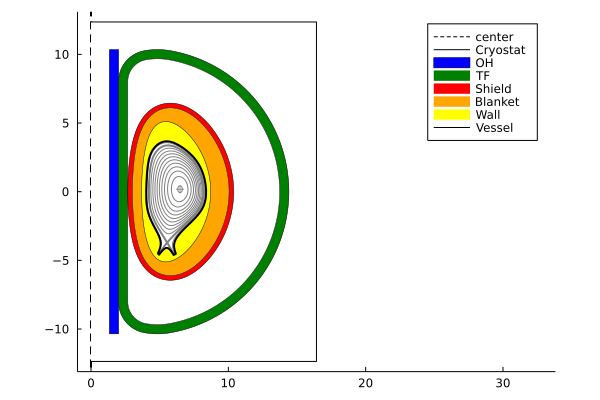

In [53]:
rb=IMAS.radial_build()
eqt=dd.equilibrium.time_slice[1]
#@show dd.radial_build.layer[3].start_radius, dd.radial_build.layer[3].end_radius
dd.radial_build.layer[3].shape = 1
println(typeof(dd.radial_build.layer[3]))
@time rbactor = FUSE.init(rb, eqt, is_nuclear_facility=true,conformal_wall=true);
FUSE.step(rbactor)
dd.radial_build = FUSE.finalize(rbactor)
plot(eqt,color=:gray)
plot!(rb,outline=true)
#display(plot!(rb,outline=false))


In [5]:
# initialize 
pfoptactor = PFcoilsOptActor(dd.equilibrium,dd.radial_build, 20, [[0.03,0.3,1-0.3,1-0.03],7], 1E-13);

plot(eqt,color=:gray)
plot!(rb)
#plot!(rb,outline=false)
plot!(pfoptactor,equilibrium=false)
# plot!(pfoptactor.pf_active,color=:magenta)
#plot(rb)
#display(plot!(pfoptactor))

LoadError: BoundsError: attempt to access 0-element Vector{IMAS.radial_build__layer} at index [0]

In [6]:
# optimize
FUSE.step(pfoptactor, λ_currents=1E5, verbose=true, symmetric=false, maxiter=10000, optimization_scheme=:mask);
plot(rb)
display(plot!(pfoptactor))

LoadError: UndefVarError: pfoptactor not defined

In [7]:
plot(rb)
display(plot!(pfoptactor,equilibrium=true,trace=true))

display(plot(pfoptactor.trace,:cost,start_at=2,yscale=:log10))#,xscale=:log,ylim=[:0.5,2]))
display(plot(pfoptactor.trace,:final_currents))

LoadError: radial_build.layer[14].outline.r is missing

In [8]:
pfoptactor = PFcoilsOptActor(dd.equilibrium,dd.radial_build, 10, [3,5],-1E-13);
eqt=pfoptactor.eq_out.time_slice[1]
heatmap(eqt.profiles_2d[1].grid.dim1,eqt.profiles_2d[1].grid.dim2,transpose(eqt.profiles_2d[1].psi),aspect_ratio=:equal)
contour!(eqt.profiles_2d[1].grid.dim1,
    eqt.profiles_2d[1].grid.dim2,
    transpose(eqt.profiles_2d[1].psi),
    levels=eqt.profiles_1d.psi,
    color=:red,
    aspect_ratio=:equal)

LoadError: BoundsError: attempt to access 0-element Vector{IMAS.radial_build__layer} at index [0]

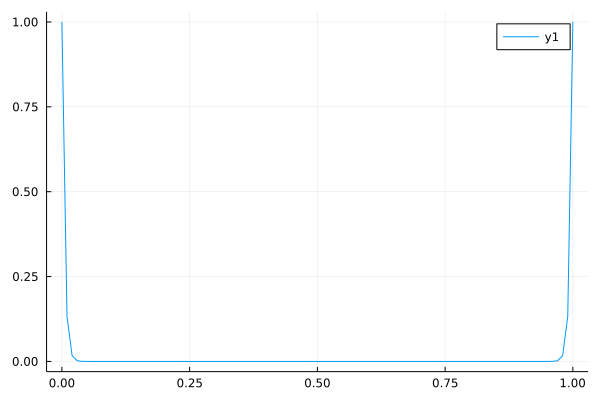

In [9]:
distances=range(0,1,length=101)
y=((distances.-0.5).*2).^100
plot(distances,y)